# Demonstrating that DST approximates the function closely and that its coefficients decay to zero if f(0) = f(1) = 0

In [20]:
# Direct Sine Transform example, based on https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.dst.html
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dst, idst
import time
%matplotlib inline

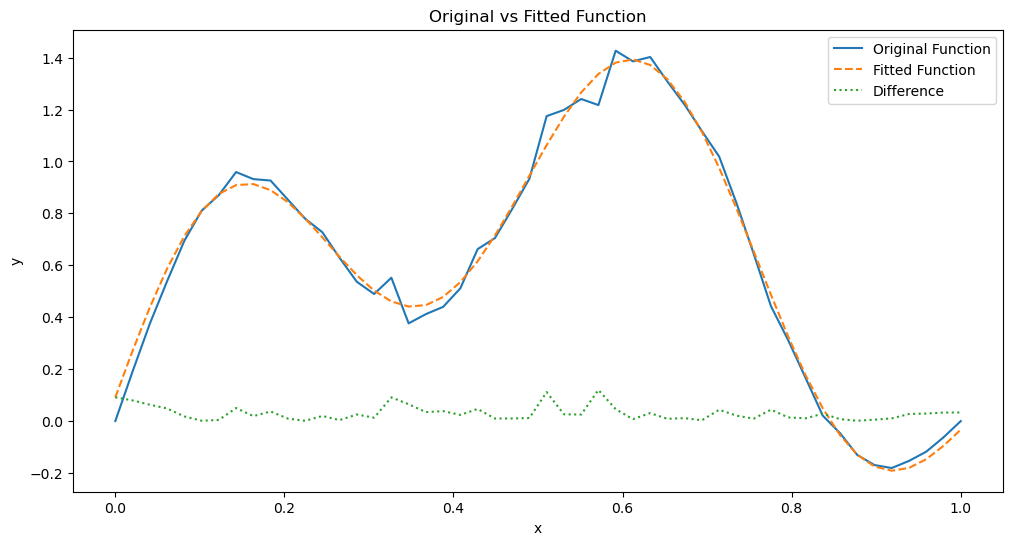

DST Coeffs:  [49.17962555  1.35170713 -1.00005217 24.15663158  0.05202897 -0.62272045
 -0.44209861 -1.08318887  0.11876882 -0.50340787 -0.8097727  -0.51795369
  0.06054548 -0.09829107 -0.17615832 -0.38267129  0.16172376 -0.68210435
 -0.47305076  0.68455577]


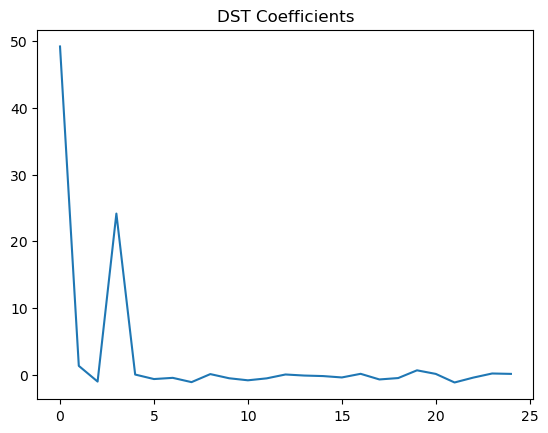

Time taken: 0.1810 seconds


In [21]:
# Parameters
DST_TYPE = 2  # See https://en.wikipedia.org/wiki/Discrete_sine_transform
NOISE_STD = 1  # Standard Dev of the noise term
N_TERMS = 5 # Number of terms to keep
N_TIMES = 50


# Step 1: Define the function on [0, 1]
def original_function(x):
	return np.sin(np.pi * x) + 0.5 * np.sin(4 * np.pi * x) \
		+ NOISE_STD * np.random.normal(size=x.size) * (x * (x - 1)) ** 2
# return x ** 4 - x


# Step 2: Perform the sine transform and approximate with the first N terms
def dst_approximation(y, N):
	y_dst = dst(y, type=DST_TYPE)
	y_dst_cropped = np.copy(y_dst)
	y_dst_cropped[N:] = 0  # Zero out all but the first N terms
	y_approx = idst(y_dst_cropped, type=DST_TYPE)
	return y_approx, y_dst


# Step 3: Calculate the difference between the fitted and original function
def calculate_difference(original, fitted):
	return np.abs(original - fitted)


# Step 4: Plot both functions
def plot_functions(x, original, fitted, difference):
	plt.figure(figsize=(12, 6))
	plt.plot(x, original, label='Original Function')
	plt.plot(x, fitted, label='Fitted Function', linestyle='--')
	plt.plot(x, difference, label='Difference', linestyle=':')
	plt.xlabel('x')
	plt.ylabel('y')
	plt.title('Original vs Fitted Function')
	plt.legend()
	plt.show()


assert max(abs(original_function(np.array([0,1])))) < 1e-10

# Step 5: Measure the time taken
start_time = time.time()

# Define the x values
x = np.linspace(0, 1, N_TIMES)

# Compute the original function values
original_values = original_function(x)

# Perform the sine transform approximation
fitted_values, dst_coeffs = dst_approximation(original_values, N_TERMS)

# Calculate the difference
difference_values = calculate_difference(original_values, fitted_values)

# Plot the functions
plot_functions(x, original_values, fitted_values, difference_values)

end_time = time.time()
print("DST Coeffs: ", dst_coeffs[:20])
plt.plot(dst_coeffs[:25])
plt.title('DST Coefficients')
plt.show()
print(f"Time taken: {end_time - start_time:.4f} seconds")

# Showing that DST coefficients converge to theoretical as the number of mesh points increases

In [22]:
import scipy.fftpack
from scipy.integrate import quad

# Define the function
def f(x):
	return x ** 0.05 - x


# Number of sample points
N_COEFFS = [10]
N_TIMES = [5, 10, 50, 100, 500, 1000]
DECIMALS = 5
# Interval [0, 1]
a, b = 0, 1


def fourier_sine_coefficients(n, f, a=0, b=1):
	a_coeffs = np.zeros(n)

	# Compute Fourier coefficients for both functions
	for n in range(1, n + 1):
		a_coeffs[n - 1], _ = quad(f, a, b, weight='sin', wvar=(n * np.pi), )

	return 2 * a_coeffs


if __name__ == "__main__":
    max_diff_list = []
    for n in N_TIMES:
        # Sample points
        x = np.linspace(a, b, n)
        y = f(x)
        
        # Compute DST-II coefficients
        dst_coefficients = scipy.fftpack.dst(y, type=2)
        # Normalize DST coefficients to match the Fourier sine series coefficients
        dst_coefficients = dst_coefficients / n  # (n + 1)
        
        # Compute Fourier sine series coefficients
        sine_series_coefficients = fourier_sine_coefficients(n, f, a, b)
        
        print(f"\nn_times={n}:")
        print("sin coeffs:\t", np.round(sine_series_coefficients[:5], DECIMALS))
        print("dst coeffs:\t", np.round(dst_coefficients[:5], DECIMALS))
        max_diff = max(abs(sine_series_coefficients - dst_coefficients))
        max_diff_rel = max(
            (abs(sine_series_coefficients - dst_coefficients
                 ) / (abs(sine_series_coefficients) + abs(dst_coefficients)) * 2
             )[:5]
        )
        print("max diff:\t", np.round(max_diff, DECIMALS), ",\trelative:", np.round(max_diff_rel * 100, DECIMALS - 2),
              "%")
        max_diff_list.append(max_diff)


n_times=5:
sin coeffs:	 [0.58572 0.28146 0.1842  0.13605 0.1077 ]
dst coeffs:	 [ 0.48369  0.17017 -0.07281 -0.10517 -0.18113]
max diff:	 0.28882 ,	relative: 200.0 %

n_times=10:
sin coeffs:	 [0.58572 0.28146 0.1842  0.13605 0.1077 ]
dst coeffs:	 [ 0.5593   0.26382  0.11029  0.06042 -0.00285]
max diff:	 0.14228 ,	relative: 200.0 %

n_times=50:
sin coeffs:	 [0.58572 0.28146 0.1842  0.13605 0.1077 ]
dst coeffs:	 [0.58431 0.28487 0.18044 0.13444 0.10209]
max diff:	 0.02623 ,	relative: 5.341 %

n_times=100:
sin coeffs:	 [0.58572 0.28146 0.1842  0.13605 0.1077 ]
dst coeffs:	 [0.58525 0.28359 0.18301 0.13614 0.10603]
max diff:	 0.01267 ,	relative: 1.561 %

n_times=500:
sin coeffs:	 [0.58572 0.28146 0.1842  0.13605 0.1077 ]
dst coeffs:	 [0.58566 0.28195 0.18407 0.13621 0.10754]
max diff:	 0.00234 ,	relative: 0.175 %

n_times=1000:
sin coeffs:	 [0.58572 0.28146 0.1842  0.13605 0.1077 ]
dst coeffs:	 [0.5857  0.28171 0.18414 0.13614 0.10763]
max diff:	 0.00113 ,	relative: 0.089 %


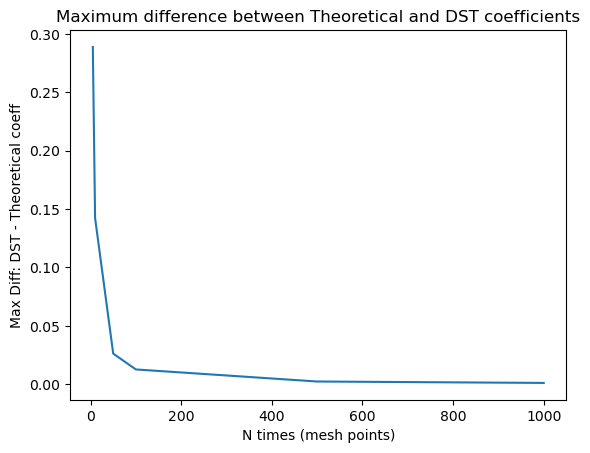

In [23]:
plt.plot(N_TIMES, max_diff_list)
plt.title("Maximum difference between Theoretical and DST coefficients")
plt.xlabel("N times (mesh points)")
plt.ylabel("Max Diff: DST - Theoretical coeff")
plt.show()